# **<center> Toxic Comment Classification </center>**

## **Problem Statement** 

### **“To build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate.”**

# **<center>Running this notebook on Kaggle for using better acceleration power for model training.<center>**

# **Import Required Libraries.**

In [2]:
import os
import re
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import groupby
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
from nltk.corpus import stopwords

In [3]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# **Loading data**

In [4]:
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

## Data Cleaning

- This step is already derived in DVC pipeline to automate the process of data cleaning.

## Removing duplicate sentence

In [5]:
# Removing duplicates, if words occured more than  2 times in comment.
def remove_duplicates(text_before):
    my_dict = dict()
    text_after = list()
    for word in text_before.split():
        if word not in my_dict.keys():
            my_dict[word] = 1
        else:
            my_dict[word] = my_dict[word] + 1
    
    for key,value in my_dict.items():
        if value>=2:
            text_after.append(key)
        else:
            text_after.append(key)
    return " ".join(text_after)

In [6]:
train['comment_text_clean'] = train['comment_text'].apply(lambda text : remove_duplicates(text))
test['comment_text_clean'] = test['comment_text'].apply(lambda text : remove_duplicates(text))
# length of comments
train['comment_text_len'] = train['comment_text_clean'].apply(lambda x : len(x.split())) 

## Clean text

In [7]:
# "clean_text" function clean the text/comments 
def clean_text(text):
    """Make text lowercase, remove text in square brackets, remove links,remove punctuation
    and remove stop words containing numbers"""
    text = text.lower()                                            # Converts the text to lowercase using regex 
    text = re.sub(r"\[.*?\]","",text)                              # Replace's the text into 'nothing" if text is present inside squre brackets.
    text = re.sub("https?://\S+|www\.\S+","",text)                 # Removes the links from the comments.
    text = re.sub("<.*?>+","",text)                                # Remove unwanted
    text = re.sub("[%s]" % re.escape(string.punctuation),"",text)  # Remove punctuations
    text = re.sub("\n","",text)                                    # Remove next line symbols '\n'
    text = re.sub("\w*\d\w*","",text)                              # Takes only albhabet and digits.
    return text
train['comment_text_clean'] = train['comment_text_clean'].apply(lambda text : clean_text(text))
test['comment_text_clean'] = test['comment_text_clean'].apply(lambda text : clean_text(text))

In [8]:
## Removing stop words


# Remove stop words from comments.
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
train['comment_text_clean'] = train['comment_text_clean'].apply(remove_stopwords)
test['comment_text_clean'] = test['comment_text_clean'].apply(remove_stopwords)



In [9]:
# define variable to training data and target data.
target_data = train[list_classes]
train_data = train['comment_text_clean']

In [10]:
# Define BERT encoder url and processing url blocks from tensorflowhub
encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" 
preprocessing = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [11]:
bert_preprocessing_model = hub.KerasLayer(preprocessing) # preprocessing step in bert-base model
bert_model = hub.KerasLayer(encoder) # BERT-base model encoder

In [17]:
text_input = tf.keras.layers.Input(shape= (),dtype = tf.string,name = 'text')
preprocessing = bert_preprocessing_model(text_input)
output = bert_model(preprocessing)

# Linear layer
layer_1 = tf.keras.layers.Dropout(0.2,name = 'dropout')(output['pooled_output'])
layer_2 = tf.keras.layers.Dense(len(list_classes),activation = 'sigmoid',name = 'output')(layer_1)

model = tf.keras.Model(inputs = [text_input],outputs = [layer_2])

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# Traning process with 10 epochs.
history = model.fit(train_data,target_data,batch_size=32, epochs=3, validation_split=0.1)

Epoch 1/3
4488/4488 [==============================] - 1152s 256ms/step - loss: 0.0996 - accuracy: 0.8457 - val_loss: 0.0833 - val_accuracy: 0.8905
Epoch 2/3
4488/4488 [==============================] - 1148s 256ms/step - loss: 0.0865 - accuracy: 0.9353 - val_loss: 0.0798 - val_accuracy: 0.9921
Epoch 3/3
4488/4488 [==============================] - 1143s 255ms/step - loss: 0.0850 - accuracy: 0.9496 - val_loss: 0.0785 - val_accuracy: 0.9923


## Model evaluations

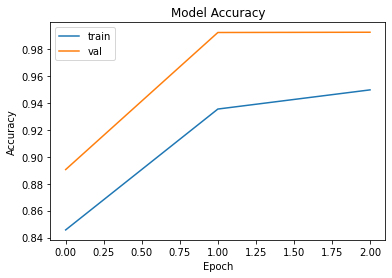

In [20]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'],loc='upper left')
plt.show()

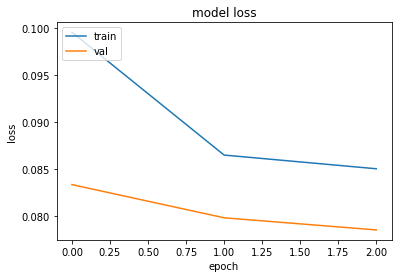

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
model.save('comment-toxicity-model')
trained_model = tf.keras.models.load_model('comment-toxicity-model')

In [23]:
# in h5 format
model.save('comment-toxicity-bert.h5')

In [24]:
## predict on test data
y_pred = model.predict([test['comment_text_clean']])

In [25]:
y_pred

array([[9.44723308e-01, 2.79726535e-01, 9.04219627e-01, 5.74326925e-02,
        8.68914127e-01, 1.63465947e-01],
       [6.55019581e-02, 2.77014216e-03, 2.98291538e-02, 6.14686636e-04,
        2.97778528e-02, 4.34153434e-03],
       [1.59042943e-02, 1.85234868e-03, 1.04092136e-02, 5.89001924e-04,
        1.04545979e-02, 1.92499976e-03],
       ...,
       [7.83141353e-04, 1.87115347e-05, 2.19224559e-04, 1.36397593e-05,
        2.70310818e-04, 1.17232717e-04],
       [2.61728512e-03, 8.63770765e-05, 4.71618812e-04, 1.14489165e-04,
        9.02129803e-04, 1.39030360e-03],
       [2.24328548e-01, 6.03006035e-03, 6.77523762e-02, 3.43211298e-03,
        1.07299365e-01, 2.20831623e-03]], dtype=float32)

## Testing on sample dataset

In [30]:
def classify(input_text, model, classes):
    trained_model = model.predict([input_text])
    output = np.where(trained_model > 0.5, 1,0)
    for i,j in zip(classes,output[0]):
        if j==1:
            print(f"{i} :\t YES")
        if j==0:
            print(f"{i} :\t NO")

In [31]:
classify('You bitch',trained_model,list_classes)

toxic :	 YES
severe_toxic :	 NO
obscene :	 YES
threat :	 NO
insult :	 YES
identity_hate :	 NO


In [34]:
classify("Fuking bastard", trained_model, list_classes)

toxic :	 YES
severe_toxic :	 NO
obscene :	 YES
threat :	 NO
insult :	 YES
identity_hate :	 NO
